In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from PIL import Image
from tqdm import tqdm
import zipfile
import shutil
from PIL import Image
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

In [30]:
#print(os.getcwd())
#my_dir = os.getcwd()
#zip_file_path = os.path.join(my_dir, "archive.zip")
#extract_path = os.path.join(my_dir, "raw-img")
import matplotlib.pyplot as plt
import numpy as np

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import itertools
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resize + Normalize input images
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, image_size=(256, 256)):
        """
        Initializes the dataset with a folder path and image size.

        Args:
        - folder_path (str): Path to the folder containing the images.
        - image_size (tuple): Desired image size (default is 256x256).
        """
        self.folder_path = folder_path
        # Get list of all image file paths in the folder
        self.image_paths = [os.path.join(folder_path, fname)
                            for fname in os.listdir(folder_path)
                            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Define image transformations (resize, to tensor, normalize)
        self.transform = transforms.Compose([
            transforms.Resize(image_size),  # Resize image to a consistent size
            transforms.ToTensor(),  # Convert to PyTorch tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
        ])

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads an image, applies transformations, and returns the image.

        Args:
        - idx (int): Index of the image to retrieve.

        Returns:
        - Transformed image (tensor).
        """
        img_path = self.image_paths[idx]  # Get the image file path at the given index
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        return self.transform(image)  # Apply transformations

# Create datasets for Monet and Photo domains
monet_dataset = SimpleImageDataset('datasetNS3/ukiyoe2photo/ukiyoe2photo/trainA')  # Path to Monet images
photo_dataset = SimpleImageDataset('datasetNS3/ukiyoe2photo/ukiyoe2photo/trainB')  # Path to Photo images

# Create DataLoader for batching the data
monet_loader = DataLoader(monet_dataset, batch_size=32, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=32, shuffle=True)

# Define simple ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

# Generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize networks
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Losses
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop (1 epoch sample)
for epoch in range(200):
    for real_A, real_B in zip(monet_loader, photo_loader):  # No unpacking into (real_A, )
        real_A = real_A[0].to(device)  # Since DataLoader returns a batch, real_A and real_B are tuples of images.
        real_B = real_B[0].to(device)  # The [0] extracts the image tensor from the tuple.

        # ----------------------
        #  Train Generators
        # ----------------------
        optimizer_G.zero_grad()

        # Translate
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        # Reconstruct
        rec_A = G_B2A(fake_B)
        rec_B = G_A2B(fake_A)

        # Dynamic labels based on PatchGAN output
        pred_fake_B = D_B(fake_B)
        pred_fake_A = D_A(fake_A)
        valid = torch.ones_like(pred_fake_B, device=device)

        # Losses
        loss_GAN_A2B = adversarial_loss(pred_fake_B, valid)
        loss_GAN_B2A = adversarial_loss(pred_fake_A, valid)
        loss_cycle_A = cycle_loss(rec_A, real_A)
        loss_cycle_B = cycle_loss(rec_B, real_B)

        loss_G = loss_GAN_A2B + loss_GAN_B2A + 10 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------
        optimizer_D_A.zero_grad()
        fake_A_detached = fake_A.detach()
        valid = torch.ones_like(D_A(real_A), device=device)
        fake = torch.zeros_like(D_A(fake_A_detached), device=device)

        loss_real = adversarial_loss(D_A(real_A), valid)
        loss_fake = adversarial_loss(D_A(fake_A_detached), fake)
        loss_D_A = (loss_real + loss_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------
        optimizer_D_B.zero_grad()
        fake_B_detached = fake_B.detach()
        valid = torch.ones_like(D_B(real_B), device=device)
        fake = torch.zeros_like(D_B(fake_B_detached), device=device)

        loss_real = adversarial_loss(D_B(real_B), valid)
        loss_fake = adversarial_loss(D_B(fake_B_detached), fake)
        loss_D_B = (loss_real + loss_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch [{epoch}] | G Loss: {loss_G.item():.4f} | D_A Loss: {loss_D_A.item():.4f} | D_B Loss: {loss_D_B.item():.4f}")

Epoch [0] | G Loss: 9.7423 | D_A Loss: 0.2373 | D_B Loss: 0.3503
Epoch [1] | G Loss: 5.7635 | D_A Loss: 0.4604 | D_B Loss: 0.2615
Epoch [2] | G Loss: 7.9811 | D_A Loss: 0.2646 | D_B Loss: 0.3015
Epoch [3] | G Loss: 7.2460 | D_A Loss: 0.1487 | D_B Loss: 0.1328
Epoch [4] | G Loss: 9.2872 | D_A Loss: 0.1962 | D_B Loss: 0.1580
Epoch [5] | G Loss: 5.6498 | D_A Loss: 0.3432 | D_B Loss: 0.2300
Epoch [6] | G Loss: 9.7237 | D_A Loss: 0.1740 | D_B Loss: 0.1091
Epoch [7] | G Loss: 8.1008 | D_A Loss: 0.2135 | D_B Loss: 0.1931
Epoch [8] | G Loss: 9.5430 | D_A Loss: 0.2492 | D_B Loss: 0.3364
Epoch [9] | G Loss: 9.1135 | D_A Loss: 0.1507 | D_B Loss: 0.1117
Epoch [10] | G Loss: 6.8129 | D_A Loss: 0.2048 | D_B Loss: 0.2511
Epoch [11] | G Loss: 6.7456 | D_A Loss: 0.2807 | D_B Loss: 0.3438
Epoch [12] | G Loss: 9.7840 | D_A Loss: 0.4255 | D_B Loss: 0.4463
Epoch [13] | G Loss: 8.7624 | D_A Loss: 0.0627 | D_B Loss: 0.0637
Epoch [14] | G Loss: 5.6863 | D_A Loss: 0.1286 | D_B Loss: 0.1603
Epoch [15] | G Loss:

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor, title=None):
    """Helper function to display images from a tensor."""
    # Ensure the tensor is on the CPU and detached from the computation graph
    image = tensor.cpu().detach().numpy()

    # Check if the image has 3 channels (RGB)
    if image.shape[0] == 3:  # RGB Image
        image = image.transpose((1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    elif image.shape[0] == 1:  # Grayscale Image (Single channel)
        image = image[0, :, :]  # Remove the channel dimension

    # Normalize to [0, 1] range for visualization
    image = (image + 1) / 2

    # Display image
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

def visualize_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, num_images=1):
    """
    Visualizes generated images by translating between Monet and Photo domains.

    Args:
    - monet_loader: DataLoader for the Monet images
    - photo_loader: DataLoader for the Photo images
    - G_A2B: Generator that translates Monet to Photo
    - G_B2A: Generator that translates Photo to Monet
    - device: PyTorch device (cuda or cpu)
    - num_images: Number of images to display (default is 1)
    """
    # Get a batch of real images from the data loaders
    for i, (real_A, real_B) in enumerate(zip(monet_loader, photo_loader)):
        if i >= num_images:
            break

        # Send images to device (GPU or CPU)
        real_A = real_A[0].to(device)  # Get the images from the DataLoader
        real_B = real_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)  # Monet -> Photo
        fake_A = G_B2A(real_B)  # Photo -> Monet

        # Visualize the images (show a batch of images from both domains)
        plt.figure(figsize=(12, 12))

        # Show Monet -> Photo (fake_B)
        plt.subplot(2, 2, 1)
        imshow(real_A[0], title="Real Monet")

        plt.subplot(2, 2, 2)
        imshow(fake_B[0], title="Fake Photo (Monet -> Photo)")

        # Show Photo -> Monet (fake_A)
        plt.subplot(2, 2, 3)
        imshow(real_B[0], title="Real Photo")

        plt.subplot(2, 2, 4)
        imshow(fake_A[0], title="Fake Monet (Photo -> Monet)")

        plt.show()
        break  # If you only want to display one batch, stop here.

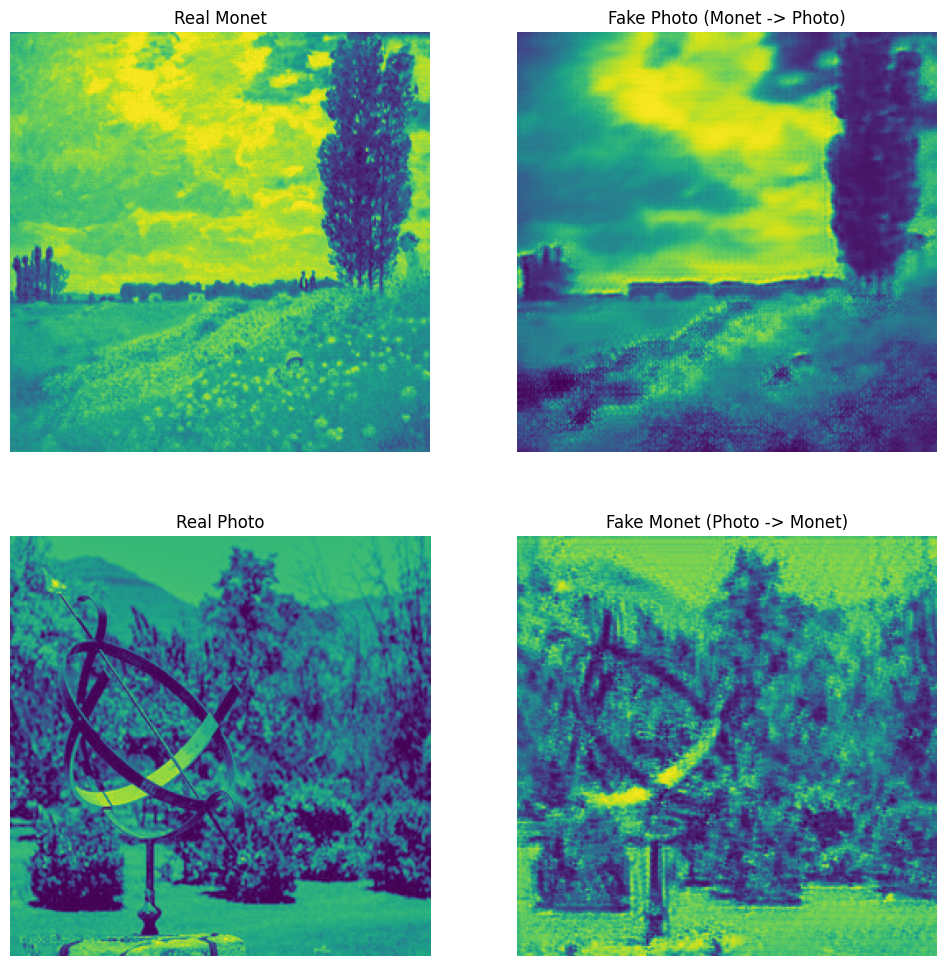

In [48]:
visualize_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, num_images=1)

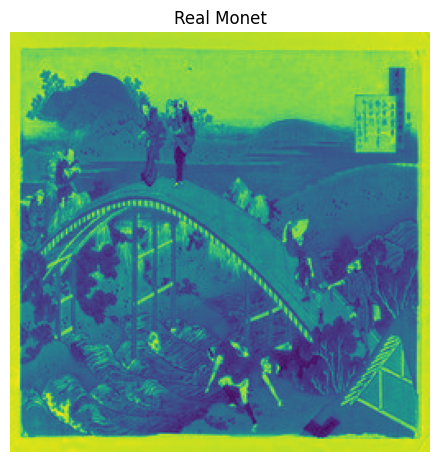

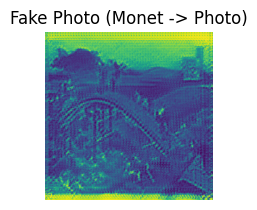

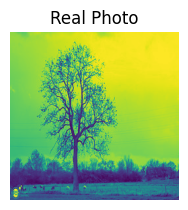

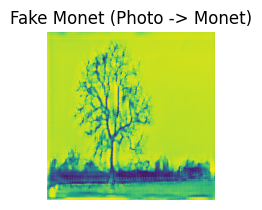

In [83]:
visualize_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, num_images=2)

In [39]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(tensor, title=None, save_path=None):
    """Helper function to display and optionally save images from a tensor."""
    # Ensure the tensor is on the CPU and detached from the computation graph
    image = tensor.cpu().detach().numpy()

    # Check if the image has 3 channels (RGB)
    if image.shape[0] == 3:  # RGB Image
        image = image.transpose((1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    elif image.shape[0] == 1:  # Grayscale Image (Single channel)
        image = image[0, :, :]  # Remove the channel dimension

    # Normalize to [0, 1] range for visualization
    image = (image + 1) / 2

    # Display image
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

    # If a save path is provided, save the image
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()  # Close the plot to avoid overlapping visuals
    else:
        plt.show()

def visualize_and_save_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, output_dir="outputs_attempt", num_images=1):
    """
    Visualizes generated images by translating between Monet and Photo domains and saves them.

    Args:
    - monet_loader: DataLoader for the Monet images
    - photo_loader: DataLoader for the Photo images
    - G_A2B: Generator that translates Monet to Photo
    - G_B2A: Generator that translates Photo to Monet
    - device: PyTorch device (cuda or cpu)
    - output_dir: Directory to save output images (default is 'outputs_attempt')
    - num_images: Number of images to display and save (default is 1)
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get a batch of real images from the data loaders
    for i, (real_A, real_B) in enumerate(zip(monet_loader, photo_loader)):
        if i >= num_images:
            break

        # Send images to device (GPU or CPU)
        real_A = real_A[0].to(device)  # Get the images from the DataLoader
        real_B = real_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)  # Monet -> Photo
        fake_A = G_B2A(real_B)  # Photo -> Monet

        # Save images and visualize them
        for idx in range(real_A.size(0)):  # Iterate over the batch
            # Define save paths
            real_A_path = os.path.join(output_dir, f"real_monet_{i * real_A.size(0) + idx}.png")
            fake_B_path = os.path.join(output_dir, f"fake_photo_{i * real_A.size(0) + idx}.png")
            real_B_path = os.path.join(output_dir, f"real_photo_{i * real_A.size(0) + idx}.png")
            fake_A_path = os.path.join(output_dir, f"fake_monet_{i * real_A.size(0) + idx}.png")

            # Visualize and save Monet -> Photo (real and fake)
            plt.figure(figsize=(12, 12))

            plt.subplot(2, 2, 1)
            imshow(real_A[idx], title="Real Monet", save_path=real_A_path)

            plt.subplot(2, 2, 2)
            imshow(fake_B[idx], title="Fake Photo (Monet -> Photo)", save_path=fake_B_path)

            # Visualize and save Photo -> Monet (real and


In [40]:
visualize_and_save_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, output_dir="outputs_attempt", num_images=1)


In [41]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(tensor, title=None, save_path=None):
    """Helper function to display and optionally save images from a tensor."""
    # Ensure the tensor is on the CPU and detached from the computation graph
    image = tensor.cpu().detach().numpy()

    # Check if the image has 3 channels (RGB)
    if image.shape[0] == 3:  # RGB Image
        image = image.transpose((1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    elif image.shape[0] == 1:  # Grayscale Image (Single channel)
        image = image[0, :, :]  # Remove the channel dimension

    # Normalize to [0, 1] range for visualization
    image = np.clip((image + 1) / 2, 0, 1)  # Clip to avoid out-of-range values

    # Display image
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

    # If a save path is provided, save the image
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the plot to avoid overlapping visuals
    else:
        plt.show()

def visualize_and_save_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, output_dir="outputs_attempt", num_images=1):
    """
    Visualizes generated images by translating between Monet and Photo domains and saves them.

    Args:
    - monet_loader: DataLoader for the Monet images
    - photo_loader: DataLoader for the Photo images
    - G_A2B: Generator that translates Monet to Photo
    - G_B2A: Generator that translates Photo to Monet
    - device: PyTorch device (cuda or cpu)
    - output_dir: Directory to save output images (default is 'outputs_attempt')
    - num_images: Number of images to display and save (default is 1)
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get a batch of real images from the data loaders
    for i, (real_A, real_B) in enumerate(zip(monet_loader, photo_loader)):
        if i >= num_images:
            break

        # Send images to device (GPU or CPU)
        real_A = real_A[0].to(device)  # Get the images from the DataLoader
        real_B = real_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)  # Monet -> Photo
        fake_A = G_B2A(real_B)  # Photo -> Monet

        # Save images and visualize them
        for idx in range(real_A.size(0)):  # Iterate over the batch
            # Define save paths
            real_A_path = os.path.join(output_dir, f"real_monet_{i * real_A.size(0) + idx}.png")
            fake_B_path = os.path.join(output_dir, f"fake_photo_{i * real_A.size(0) + idx}.png")
            real_B_path = os.path.join(output_dir, f"real_photo_{i * real_A.size(0) + idx}.png")
            fake_A_path = os.path.join(output_dir, f"fake_monet_{i * real_A.size(0) + idx}.png")

            # Visualize and save Monet -> Photo (real and fake)
            plt.figure(figsize=(12, 12))

            plt.subplot(2, 2, 1)
            imshow(real_A[idx], title="Real Monet", save_path=real_A_path)

            plt.subplot(2, 2, 2)
            imshow(fake_B[idx], title="Fake Photo (Monet -> Photo)", save_path=fake_B_path)

            # Visualize and save Photo -> Monet (real and fake)
            plt.subplot(2, 2, 3)
            imshow(real_B[idx], title="Real Photo", save_path=real_B_path)

            plt.subplot(2, 2, 4)
            imshow(fake_A[idx], title="Fake Monet (Photo -> Monet)", save_path=fake_A_path)

            plt.close()  # Close the figure to avoid overlap of images in subsequent iterations

        break  # If you only want to display and save one batch, stop here.


In [42]:
visualize_and_save_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, output_dir="outputs_attempt", num_images=1)


In [49]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(tensor, title=None, save_path=None):
    """Helper function to display and optionally save images from a tensor."""
    # Ensure the tensor is on the CPU and detached from the computation graph
    image = tensor.cpu().detach().numpy()

    # Check if the image has 3 channels (RGB)
    if image.shape[0] == 3:  # RGB Image
        image = image.transpose((1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    elif image.shape[0] == 1:  # Grayscale Image (Single channel)
        image = image[0, :, :]  # Remove the channel dimension

    # Normalize to [0, 1] range for visualization
    image = np.clip((image + 1) / 2, 0, 1)  # Clip to avoid out-of-range values

    # Display image
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide the axes

    # If a save path is provided, save the image
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the plot to avoid overlapping visuals
    else:
        plt.show()  # Display the image interactively in the IDE

def visualize_and_save_generated_images(monet_loader, photo_loader, G_A2B, G_B2A, device, output_dir="outputs_attempt", num_images=1):
    """
    Visualizes generated images by translating between Monet and Photo domains and saves them.

    Args:
    - monet_loader: DataLoader for the Monet images
    - photo_loader: DataLoader for the Photo images
    - G_A2B: Generator that translates Monet to Photo
    - G_B2A: Generator that translates Photo to Monet
    - device: PyTorch device (cuda or cpu)
    - output_dir: Directory to save output images (default is 'outputs_attempt')
    - num_images: Number of images to display and save (default is 1)
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get a batch of real images from the data loaders
    for i, (real_A, real_B) in enumerate(zip(monet_loader, photo_loader)):
        if i >= num_images:
            break

        # Send images to device (GPU or CPU)
        real_A = real_A[0].to(device)  # Get the images from the DataLoader
        real_B = real_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)  # Monet -> Photo
        fake_A = G_B2A(real_B)  # Photo -> Monet

        # Save images and visualize them
        for idx in range(real_A.size(0)):  # Iterate over the batch
            # Define save paths
            real_A_path = os.path.join(output_dir, f"real_monet_{i * real_A.size(0) + idx}.png")
            fake_B_path = os.path.join(output_dir, f"fake_photo_{i * real_A.size(0) + idx}.png")
            real_B_path = os.path.join(output_dir, f"real_photo_{i * real_A.size(0) + idx}.png")
            fake_A_path = os.path.join(output_dir, f"fake_monet_{i * real_A.size(0) + idx}.png")

            # Visualize and save Monet -> Photo (real and fake)
            plt.figure(figsize=(12, 12))

            plt.subplot(2, 2, 1)
            imshow(real_A[idx], title="Real Monet", save_path=real_A_path)

            plt.subplot(2, 2, 2)
            imshow(fake_B[idx], title="Fake Photo (Monet -> Photo)", save_path=fake_B_path)

            # Visualize and save Photo -> Monet (real and fake)
            plt.subplot(2, 2, 3)
            imshow(real_B[idx], title="Real Photo", save_path=real_B_path)

            plt.subplot(2, 2, 4)
            imshow(fake_A[idx], title="Fake Monet (Photo -> Monet)", save_path=fake_A_path)

            plt.show()  # This will display the figure interactively in the IDE

        break  # If you only want to display and save one batch, stop here.


In [82]:
visualize_and_save_generated_images(
    monet_loader=monet_loader,
    photo_loader=photo_loader,
    G_A2B=G_A2B,
    G_B2A=G_B2A,
    device=device,
    output_dir="outputsjap_attempt10",
    num_images=10
)


In [56]:
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import os

def load_and_preprocess_image(image_path, device, image_size=256):
    """Loads and preprocesses a single image for the model."""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

def tensor_to_image(tensor):
    """Converts a tensor to a displayable image."""
    image = tensor.squeeze(0).cpu().detach().numpy()
    image = (image + 1) / 2  # De-normalize to [0, 1]
    image = image.transpose((1, 2, 0))  # Convert to (H, W, C)
    return image

def run_model_on_image(image_path, model, output_dir="outputs_specific", device="cpu"):
    os.makedirs(output_dir, exist_ok=True)

    # Load and preprocess the image
    input_tensor = load_and_preprocess_image(image_path, device)

    # Generate output
    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Convert tensors to images
    input_image = tensor_to_image(input_tensor)
    output_image = tensor_to_image(output_tensor)

    # Plot both
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title("Generated Output")
    plt.axis("off")
    plt.show()

    # Save outputs
    input_pil = Image.fromarray((input_image * 255).astype("uint8"))
    output_pil = Image.fromarray((output_image * 255).astype("uint8"))

    base_name = os.path.basename(image_path).split('.')[0]
    input_pil.save(os.path.join(output_dir, f"{base_name}_input.png"))
    output_pil.save(os.path.join(output_dir, f"{base_name}_output.png"))

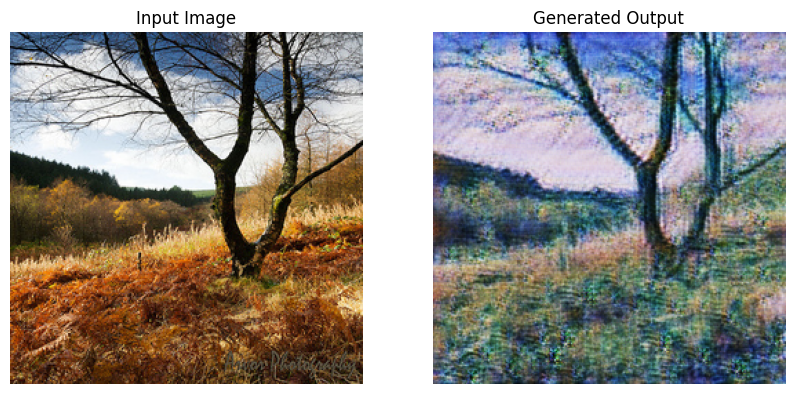

In [57]:
image_path = "datasetNS3/monet2photo/monet2photo/trainB/2013-11-30 10_02_05.jpg"  # Replace with your file path
run_model_on_image(image_path, G_B2A, device=device)  # Or G_A2B

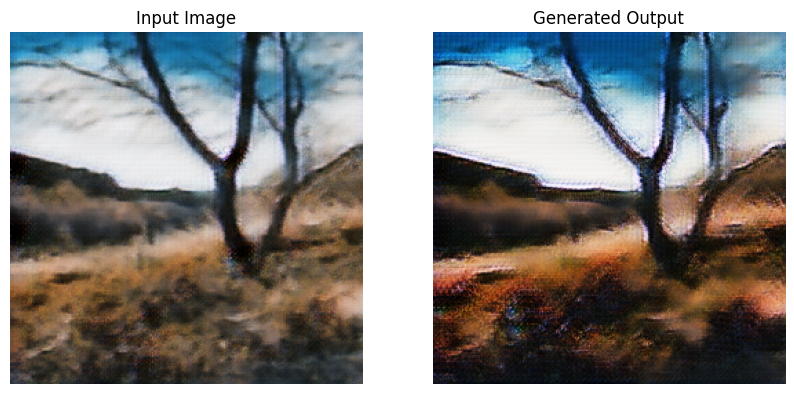

In [59]:
image_path = "outputs_specific/2013-11-30 10_02_05_output_output.png"
run_model_on_image(image_path, G_A2B, device=device)